### Import libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

### Load YOLO model

In [2]:
net = cv2.dnn.readNet('weights/yolov3.weights', 'cfg/yolov3.cfg')

In [3]:
layer_names = net.getLayerNames()
output_layers = [layer_names[i-1] for i in net.getUnconnectedOutLayers().ravel()]

len(layer_names)

254

In [4]:
# name of classes on which the model was trained on
with open('coco.names', 'r') as f:
    classes = [line.strip() for line in f]

len(classes)

80

In [5]:
# set color for each individual classes
colors = np.random.uniform(0, 255, size=(len(classes), 3))

### Load image

In [6]:
img = cv2.imread('../Images/room_ser.jpg')
img = cv2.resize(img, None, fx=0.4, fy=0.4)      # (width, height) -> (1600, 900) will look better in this code settings
height, width, channels = img.shape

width, height, channels

(1600, 900, 3)

### Preprocessing
We can’t feed the full image to the network. First we need it to convert it to blob.

<b>The input to the network is a so-called blob object.
 A blob is a 4D numpy array object (images, channels, width, height).

YOLO accepts three sizes:</b>

- <b>320×320</b> it’s small so less accuracy but better speed
- <b>609×609</b> it’s bigger so high accuracy and slow speed
- <b>416×416</b> it’s in the middle and you get a bit of both.

In [7]:
blob = cv2.dnn.blobFromImage(image=img, scalefactor=1/255.0, size=(416, 416), swapRB=True, crop=False)

blob.shape

(1, 3, 416, 416)

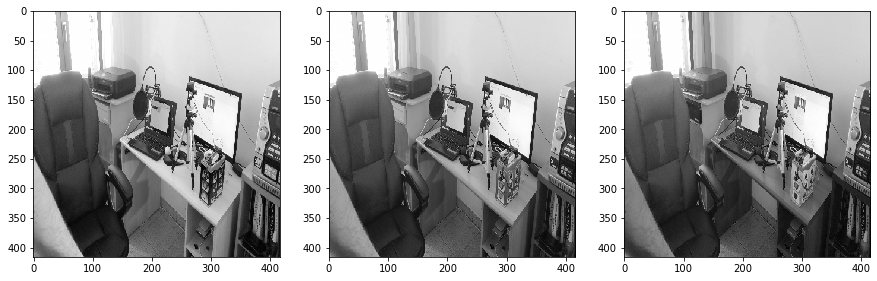

In [8]:
for b in blob:
    fig, ax = plt.subplots(1, channels, figsize=(15, 5))
    for i, img_blob in enumerate(b):
        ax[i].imshow(img_blob, cmap='gray')

Each image is blob of each channel (RGB).

### Forward Propagation

In [9]:
net.setInput(blob)
outputs = net.forward(output_layers)

len(outputs)

3

<b>The outputs object are vectors of lenght 85</b>

- 4x the bounding box (centerX, centerY, width, height)
- 1x box confidence
- 80x class confidence

In [10]:
print(outputs[0].shape)
print(outputs[1].shape)
print(outputs[2].shape)

(507, 85)
(2028, 85)
(8112, 85)


<b>The YOLO network has 3 outputs:</b>

- 507 (13 x 13 x 3) for large objects
- 2028 (26 x 26 x 3) for medium objects
- 8112 (52 x 52 x 3) for small objects

### Bounding Boxes

In [11]:
boxes = []
confidences = []
class_ids = []

for output in outputs:
    for detection in output:
        scores = detection[5:]
        class_id = np.argmax(scores)
        confidence = scores[class_id]
        if confidence > 0.5:
            # Object detected
            center_x = int(detection[0] * width)
            center_y = int(detection[1] * height)
            w = int(detection[2] * width)
            h = int(detection[3] * height)
            
            # Rectangle co-ordinates
            x = int(center_x - (w / 2))
            y = int(center_y - (h / 2))
                        
            boxes.append([x, y, w, h])
            confidences.append(float(confidence))
            class_ids.append(class_id)
            
print('Total objects detected :', len(set(class_ids)))

Total objects detected : 4


### Non-max suppression
<img src="nms_algo.png" width=600>

In [12]:
indices = cv2.dnn.NMSBoxes(bboxes=boxes, scores=confidences, score_threshold=0.5, nms_threshold=0.4)

indices

array([[ 2],
       [ 5],
       [ 8],
       [12]], dtype=int32)

<table>
    <tr>
        <th style="text-align: center;"> Before NMS </th>
        <th style="text-align: center;"> After NMS </th>
    <tr>
    <tr>
        <td><img src="before_nms.png"></td>
        <td><img src="after_nms.png"></td>
    <tr>
</table>

In [13]:
for i, box in enumerate(boxes):
    if i in indices:
        x, y, w, h = box
        label = str(classes[class_ids[i]])
        color = colors[class_ids[i]]

        cv2.rectangle(img, (x, y), (x+w, y+h), color=color, thickness=2)
        text = "{}: {:.4f}".format(classes[class_ids[i]], confidences[i])
        cv2.putText(img=img, text=text, org=(x, y-5), fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=1, color=color, thickness=2)

### Output

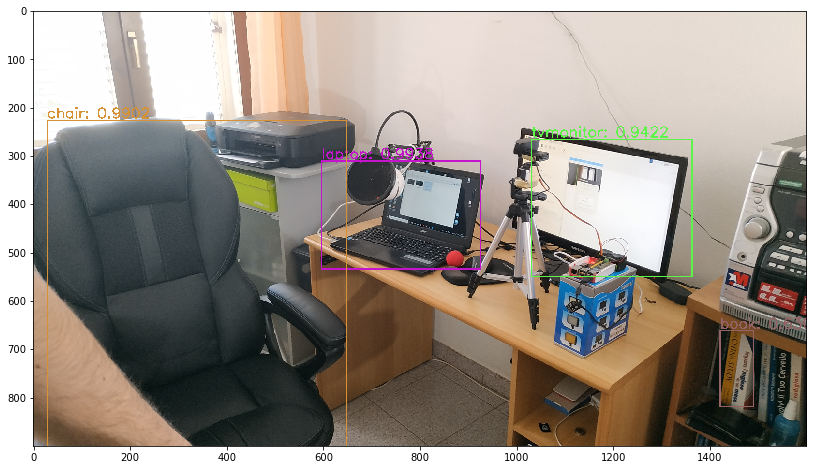

In [14]:
plt.figure(figsize=(15, 8))
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

### References
- <a href="https://opencv-tutorial.readthedocs.io/en/latest/yolo/yolo.html">opencv-tutorial</a>
- <a href="https://pysource.com/2019/06/27/yolo-object-detection-using-opencv-with-python/#">pysource</a>